#**Section 1**

In [ ]:
%pip install healpy
%pip install dustmaps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.8/754.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic
import astropy.units as u
from itertools import product
import ipywidgets as widgets
from IPython.display import display, Markdown
from astropy.cosmology import Planck18 as cosmo
import pickle
from dustmaps.sfd import SFDQuery
import os
import matplotlib.colors as mcolors


from dustmaps.config import config
config.reset()

from dustmaps.config import config
config['data_dir'] = '/content/dustmaps'

import dustmaps.sfd
dustmaps.sfd.fetch()

/usr/local/lib/python3.11/dist-packages/dustmaps/config.py:74: ConfigWarning: Configuration file not found:

    /root/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.
  warn(('Configuration file not found:\n\n'


 64.0 MiB of 64.0 MiB |  11.7 MiB/s |################## |  99% | ETA:   0:00:00

 61.9 MiB of 64.0 MiB |   9.8 MiB/s |################## |  96% | ETA:   0:00:00

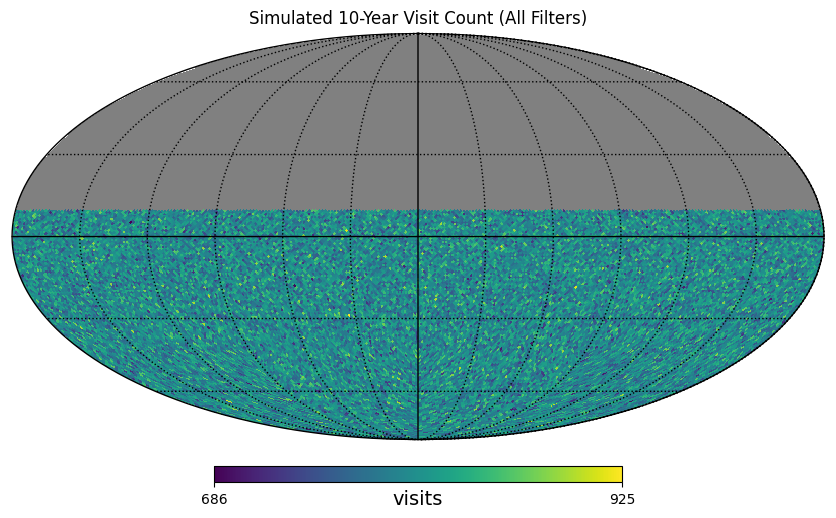

Saved mock cadence to 'mock_cadence.pkl'.


In [ ]:
# Define sky resolution
nside = 64
npix = hp.nside2npix(nside)

# Simulate southern sky coverage (Dec < 10 deg)
th, ph = hp.pix2ang(nside, np.arange(npix))
dec = np.degrees(0.5 * np.pi - th)
sky_mask = dec < 10  # Southern sky only

# Survey setup
years = 10
filters = ['u', 'g', 'r', 'i', 'z', 'y']
obs_per_year = {
    'u': 5, 'g': 10, 'r': 20, 'i': 20, 'z': 15, 'y': 10  # Rubin v4.3.1 approximations
}

mock_cadence = {f: [] for f in filters}
mock_mjds = {f: [] for f in filters}
pixel_obs_times = {f: {} for f in filters}  # Added for downstream use

rng = np.random.default_rng(42)  # reproducibility

# Create container with pixel indices as top-level keys
pixel_obs_times = {}

for f in filters:
    for y in range(years):
        mjd_start = 60980.5 + y * 365.25
        for pix in np.where(sky_mask)[0]:
            n_visits = rng.poisson(obs_per_year[f])
            if n_visits > 0:
                times = rng.uniform(mjd_start, mjd_start + 365.25, size=n_visits)
                mock_cadence[f].append((pix, n_visits))
                mock_mjds[f].append((pix, times))

                if pix not in pixel_obs_times:
                    pixel_obs_times[pix] = {}
                if f not in pixel_obs_times[pix]:
                    pixel_obs_times[pix][f] = times
                else:
                    pixel_obs_times[pix][f] = np.concatenate([pixel_obs_times[pix][f], times])

# Sort the MJD times
for pix in pixel_obs_times:
    for f in pixel_obs_times[pix]:
        pixel_obs_times[pix][f] = np.sort(pixel_obs_times[pix][f])

# Compute total visit map (all filters)
visit_map = np.zeros(npix)
for f in filters:
    for pix, n in mock_cadence[f]:
        visit_map[pix] += n
visit_map[~sky_mask] = hp.UNSEEN

# Plot total visit count
hp.mollview(visit_map, title='Simulated 10-Year Visit Count (All Filters)', unit='visits', cmap='viridis')
hp.graticule()
plt.show()

# Save cadence map for downstream use (SNR calc, injection)
with open('mock_cadence.pkl', 'wb') as f:
    pickle.dump(pixel_obs_times, f)
print("Saved mock cadence to 'mock_cadence.pkl'.")

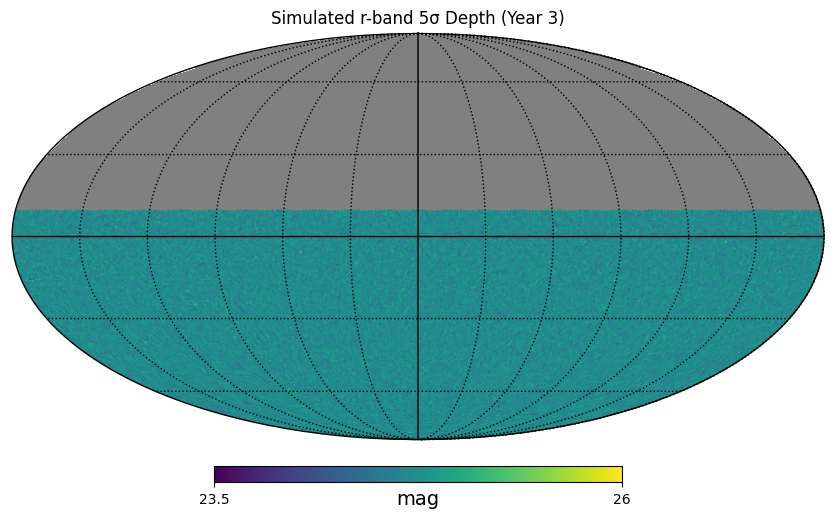

In [ ]:
# Focus on r-band, Year 3
year_index = 2  # Year 3
depth_map = np.full(npix, hp.UNSEEN)
visit_counts = np.zeros(npix)

for pix, times in mock_mjds['r']:
    times_in_year = times[(times >= 60980.5 + year_index * 365.25) &
                          (times < 60980.5 + (year_index + 1) * 365.25)]
    n_visits = len(times_in_year)
    if n_visits > 0:
        visit_counts[pix] = n_visits
        simulated_depths = rng.normal(loc=24.7, scale=0.3, size=n_visits)
        depth_map[pix] = np.median(simulated_depths)  # could also test mean or min

# Plot median depth in r-band for Year 3
hp.mollview(depth_map, title='Simulated r-band 5σ Depth (Year 3)', unit='mag', cmap='viridis', min=23.5, max=26.0)
hp.graticule()
plt.show()

#**Section 1B**

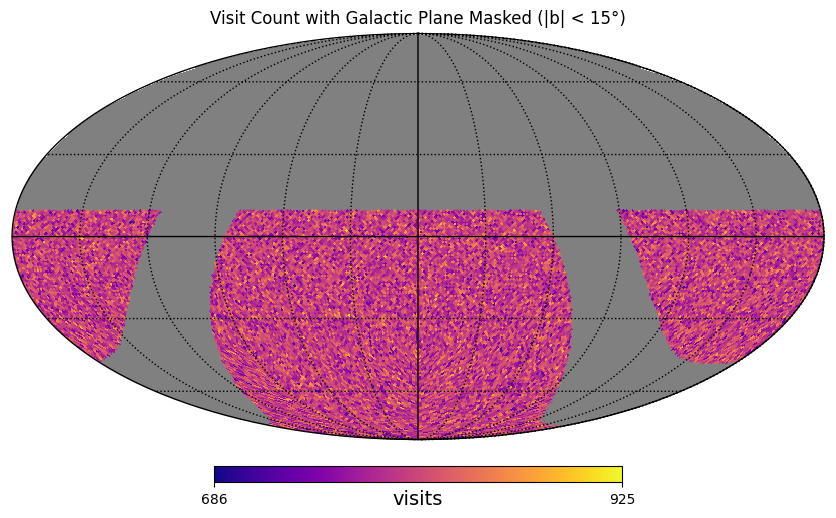

In [ ]:
# Use nside from Section 1
pix_indices = np.arange(npix)
th, ph = hp.pix2ang(nside, pix_indices)
ra = np.degrees(ph)
dec = np.degrees(0.5 * np.pi - th)

# Convert to Galactic coordinates
sky_coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
gal_lat = sky_coords.galactic.b.deg

# Apply Galactic plane mask: exclude |b| < 15 deg
galactic_mask = np.abs(gal_lat) >= 15

# Apply mask to visit map
masked_visits = np.copy(visit_map)
masked_visits[~galactic_mask] = hp.UNSEEN

# Plot masked visit count map
hp.mollview(masked_visits, title="Visit Count with Galactic Plane Masked (|b| < 15°)", unit='visits', cmap='plasma')
hp.graticule()
plt.show()



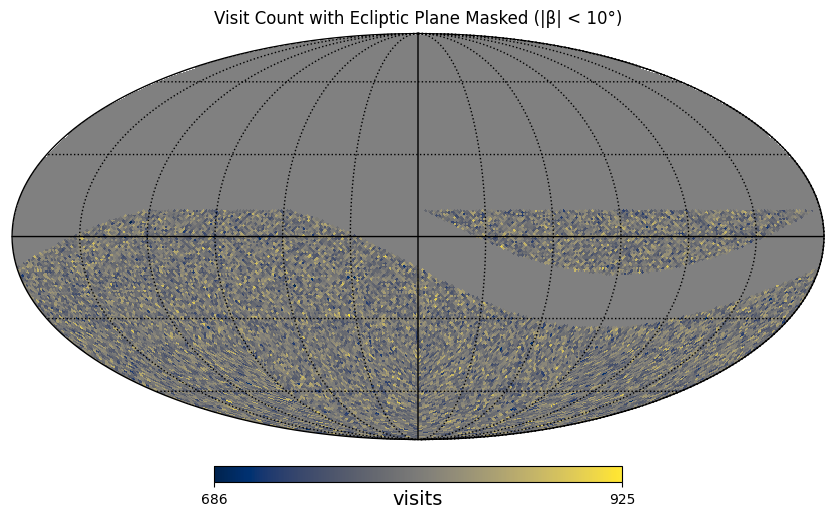

In [ ]:

# Mask the ecliptic plane (|β| < 10°)
ecl_coords = sky_coords.transform_to(GeocentricTrueEcliptic())
eclip_lat = ecl_coords.lat.deg
ecliptic_mask = np.abs(eclip_lat) >= 10

masked_ecliptic_map = np.copy(visit_map)
masked_ecliptic_map[~ecliptic_mask] = hp.UNSEEN

hp.mollview(masked_ecliptic_map,
            title="Visit Count with Ecliptic Plane Masked (|β| < 10°)",
            unit='visits', cmap='cividis')
hp.graticule()
plt.show()


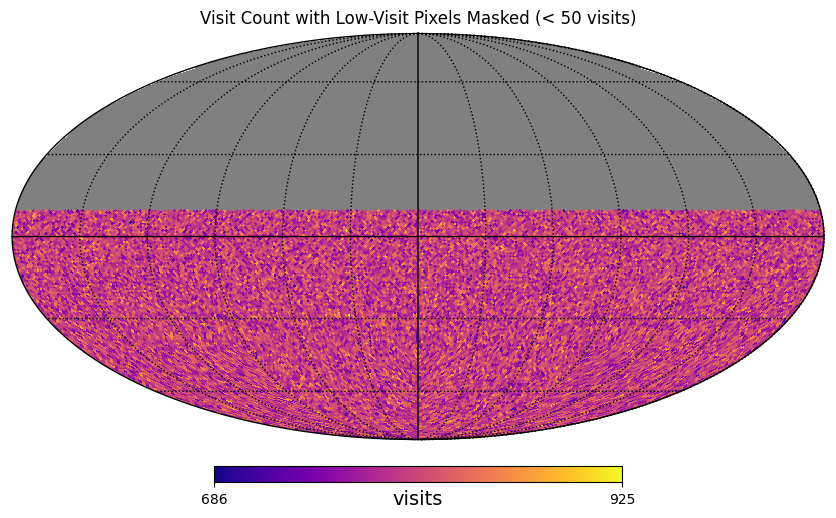

In [ ]:
# Mask pixels with < 50 visits
low_visit_mask = visit_map >= 50
masked_low_visit_map = np.copy(visit_map)
masked_low_visit_map[~low_visit_mask] = hp.UNSEEN

hp.mollview(masked_low_visit_map,
            title="Visit Count with Low-Visit Pixels Masked (< 50 visits)",
            unit='visits', cmap='plasma')
hp.graticule()
plt.show()


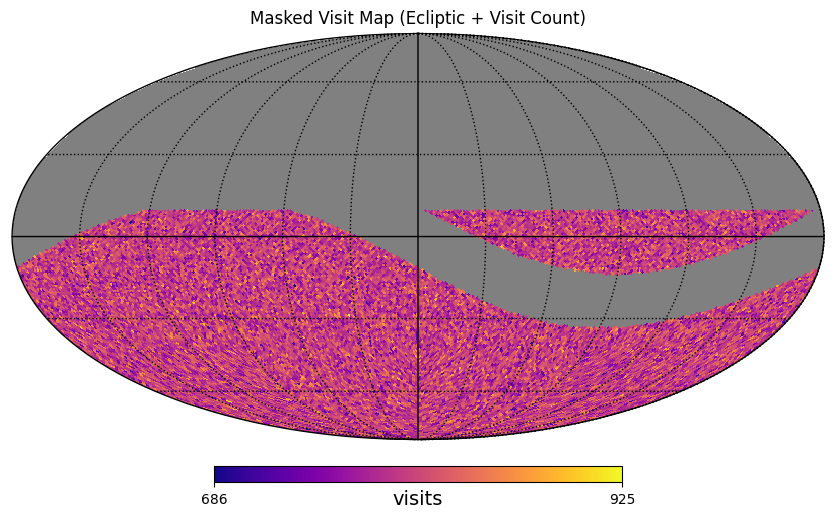

Saved masked cadence with 23253 pixels to 'mock_cadence_masked.pkl'


In [ ]:
# Combined Ecliptic + Low-Visit Mask — Apply to Saved Cadence and Export


# Load previously saved cadence dictionary
with open('mock_cadence.pkl', 'rb') as f:
    pixel_obs_times = pickle.load(f)

# Rebuild visit_map to apply visit-based masking
visit_map = np.zeros(npix)
for pix in pixel_obs_times:
    for f in pixel_obs_times[pix]:
        visit_map[pix] += len(pixel_obs_times[pix][f])

# Convert to sky coordinates
pix_indices = np.arange(npix)
th, ph = hp.pix2ang(nside, pix_indices)
ra = np.degrees(ph)
dec = np.degrees(0.5 * np.pi - th)

sky_coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Ecliptic latitude mask (|β| ≥ 10°)
ecl_coords = sky_coords.transform_to(GeocentricTrueEcliptic())
eclip_lat = ecl_coords.lat.deg
ecliptic_mask = np.abs(eclip_lat) >= 10

# Visit count mask (≥ 50 visits)
low_visit_mask = visit_map >= 50

# Combine masks
combined_mask = ecliptic_mask & low_visit_mask
masked_map = np.copy(visit_map)
masked_map[~combined_mask] = hp.UNSEEN

# Plot masked visit map
hp.mollview(masked_map, title="Masked Visit Map (Ecliptic + Visit Count)", unit='visits', cmap='plasma')
hp.graticule()
plt.show()

# Apply mask to cadence dictionary
pixel_obs_times_masked = {}
for pix in pixel_obs_times:
    if pix < len(combined_mask) and combined_mask[pix]:
        pixel_obs_times_masked[pix] = pixel_obs_times[pix]

# Save masked cadence
with open('mock_cadence_masked.pkl', 'wb') as f:
    pickle.dump(pixel_obs_times_masked, f)

print(f"Saved masked cadence with {len(pixel_obs_times_masked)} pixels to 'mock_cadence_masked.pkl'")


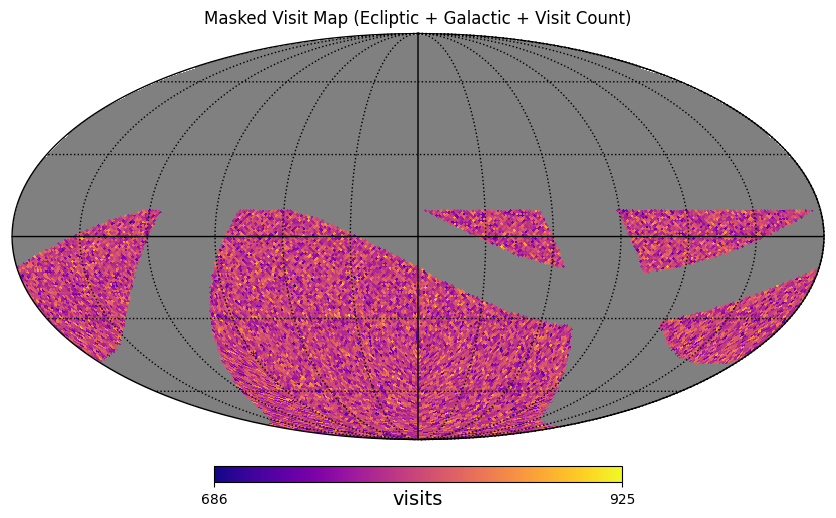

Saved masked cadence with 16914 pixels to 'mock_cadence_masked.pkl'


In [ ]:
# All combined

# Load previously saved cadence dictionary
with open('mock_cadence.pkl', 'rb') as f:
    pixel_obs_times = pickle.load(f)

# Rebuild visit_map to apply visit-based masking
visit_map = np.zeros(npix)
for pix in pixel_obs_times:
    for f in pixel_obs_times[pix]:
        visit_map[pix] += len(pixel_obs_times[pix][f])

# Convert to sky coordinates
pix_indices = np.arange(npix)
th, ph = hp.pix2ang(nside, pix_indices)
ra = np.degrees(ph)
dec = np.degrees(0.5 * np.pi - th)

sky_coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Apply Galactic plane mask: exclude |b| < 15 deg

gal_lat = sky_coords.galactic.b.deg
galactic_mask = np.abs(gal_lat) >= 15

# Apply mask to visit map
masked_visits = np.copy(visit_map)
masked_visits[~galactic_mask] = hp.UNSEEN


# Ecliptic latitude mask (|β| ≥ 10°)
ecl_coords = sky_coords.transform_to(GeocentricTrueEcliptic())
eclip_lat = ecl_coords.lat.deg
ecliptic_mask = np.abs(eclip_lat) >= 10

# Visit count mask (≥ 50 visits)
low_visit_mask = visit_map >= 50

# Combine masks
combined_mask = ecliptic_mask & low_visit_mask & galactic_mask
masked_map = np.copy(visit_map)
masked_map[~combined_mask] = hp.UNSEEN

# Plot masked visit map
hp.mollview(masked_map, title="Masked Visit Map (Ecliptic + Galactic + Visit Count)", unit='visits', cmap='plasma')
hp.graticule()
plt.show()

# Apply mask to cadence dictionary
pixel_obs_times_masked = {}
for pix in pixel_obs_times:
    if pix < len(combined_mask) and combined_mask[pix]:
        pixel_obs_times_masked[pix] = pixel_obs_times[pix]

# Save masked cadence
with open('mock_cadence_masked.pkl', 'wb') as f:
    pickle.dump(pixel_obs_times_masked, f)

print(f"Saved masked cadence with {len(pixel_obs_times_masked)} pixels to 'mock_cadence_masked.pkl'")


#**Section 3**

In [ ]:
# Define a simplified parameter grid (mimicking Bulla's models)

# Define possible values for each parameter
mej_dyn_vals = [0.001, 0.005, 0.01]
mej_wind_vals = [0.01, 0.05, 0.1]
phi_vals = [15, 30, 45]
theta_vals = [0, 30, 60]

# Create parameter combinations
parameter_grid = list(product(mej_dyn_vals, mej_wind_vals, phi_vals, theta_vals))

print(f"Total combinations: {len(parameter_grid)}")


Total combinations: 81


In [ ]:
def generate_kn_lightcurve(mej_dyn, mej_wind, phi, theta, filtername, t_peak=0, t_range=(-1, 7), npts=50, seed=42):
    """
    Generate a simplified kilonova light curve based on physical parameters and filter.

    Parameters:
        mej_dyn : float
            Dynamical ejecta mass in solar masses.
        mej_wind : float
            Wind ejecta mass in solar masses.
        phi : float
            Half-opening angle of ejecta (degrees).
        theta : float
            Viewing angle (degrees).
        filtername : str
            One of 'u', 'g', 'r', 'i', 'z', 'y'.
        t_peak : float
            Time of peak in days.
        t_range : tuple
            Start and end time relative to peak.
        npts : int
            Number of time points.

    Returns:
        t : np.ndarray
            Time array in days.
        mag : np.ndarray
            Absolute magnitude array (extinction and distance modulus applied during injection).
    """
    # Define light curve parameter ranges per filter
    lc_params = {
        'u': {'rise': (0.25, 4.75), 'fade': (0.5, 1.8),  'peak': (-15.5, -13.5),  'dur': 0.1},
        'g': {'rise': (0.25, 4.75), 'fade': (0.5, 1.6),  'peak': (-15.5, -14.0),  'dur': 0.3},
        'r': {'rise': (0.5, 4.75),  'fade': (0.4, 1.2),  'peak': (-15.5, -13.0),  'dur': 0.7},
        'i': {'rise': (0.5, 4.75),  'fade': (0.3, 0.9),  'peak': (-16.0, -13.0),  'dur': 1.0},
        'z': {'rise': (0.5, 4.5),   'fade': (0.2, 0.8),  'peak': (-16.0, -13.5),  'dur': 1.5},
        'y': {'rise': (0.25, 4.75), 'fade': (0.2, 0.7),  'peak': (-16.5, -13.5),  'dur': 2.0},
    }

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    # Validate filter
    if filtername not in lc_params:
        raise ValueError(f"Unknown filter: {filtername}")

    # Sample parameters from ranges
    p = lc_params[filtername]
    rise_rate = rng.uniform(*p['rise'])         # mag/day
    fade_rate = rng.uniform(*p['fade'])         # mag/day
    peak_mag_abs = rng.uniform(*p['peak'])      # absolute magnitude
    duration_peak = p['dur']                    # fixed per filter

    # Brightness adjustment from physical parameters (toy model)
    theta_factor = 0.01 * (theta / 30.0)
    brightness_offset = -1.5 * mej_dyn - 0.5 * mej_wind + theta_factor
    peak_mag = peak_mag_abs + brightness_offset

    # Time array
    t = np.linspace(t_range[0], t_range[1], npts)
    t_rel = t - t_peak

    # Light curve shape
    mag = np.zeros_like(t_rel)
    rise = t_rel < 0
    flat = (t_rel >= 0) & (t_rel <= duration_peak)
    fade = t_rel > duration_peak

    mag[rise] = peak_mag - rise_rate * t_rel[rise]
    mag[flat] = peak_mag
    mag[fade] = peak_mag + fade_rate * (t_rel[fade] - duration_peak)

    return t, mag

In [ ]:
# ------------------------------------------------------------
# Generate KNe Template Library
# ------------------------------------------------------------
def generateKNeTemplates(save_as='KNe_templates.pkl', filters=['u', 'g', 'r', 'i', 'z', 'y'], verbose=True):
    mej_dyn_vals = [0.001, 0.005, 0.01]
    mej_wind_vals = [0.01, 0.05, 0.1]
    phi_vals = [15, 30, 45]
    theta_vals = [0, 30, 60]

    parameter_grid = list(product(mej_dyn_vals, mej_wind_vals, phi_vals, theta_vals))

    templates = []
    for idx, (mej_dyn, mej_wind, phi, theta) in enumerate(parameter_grid):
        entry = {
            'params': {
                'mej_dyn': mej_dyn,
                'mej_wind': mej_wind,
                'phi': phi,
                'theta': theta
            },
            'lightcurve': {}
        }
        for f in filters:
            seed = hash(f"{idx}_{f}") % (2**32)  # consistent per template+filter
            t, mag = generate_kn_lightcurve(mej_dyn, mej_wind, phi, theta, f, seed=seed)
            entry['lightcurve'][f] = {'t': t, 'mag': mag}

        templates.append(entry)

        if verbose and (idx % 10 == 0):
            print(f"Generated template {idx+1}/{len(parameter_grid)}")

    with open(save_as, 'wb') as f:
        pickle.dump(templates, f)

    print(f"\n Saved {len(templates)} kilonova templates to '{save_as}'.")



In [ ]:
# RUN THIS CELL

#Example usage
generateKNeTemplates()

Generated template 1/81
Generated template 11/81
Generated template 21/81
Generated template 31/81
Generated template 41/81
Generated template 51/81
Generated template 61/81
Generated template 71/81
Generated template 81/81

 Saved 81 kilonova templates to 'KNe_templates.pkl'.


Loaded 81 kilonova templates.


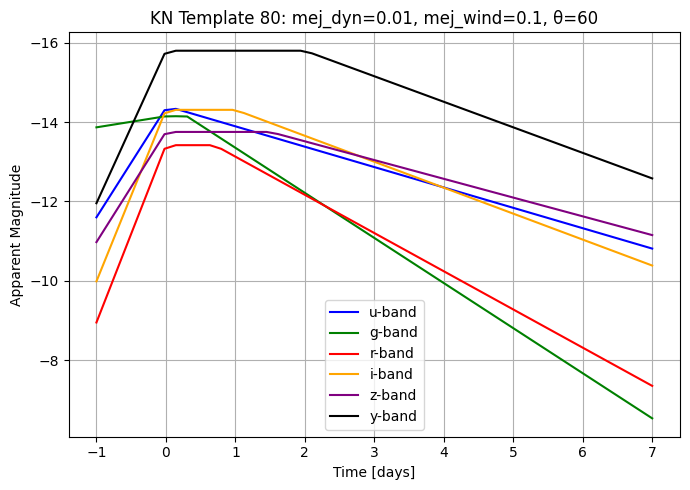

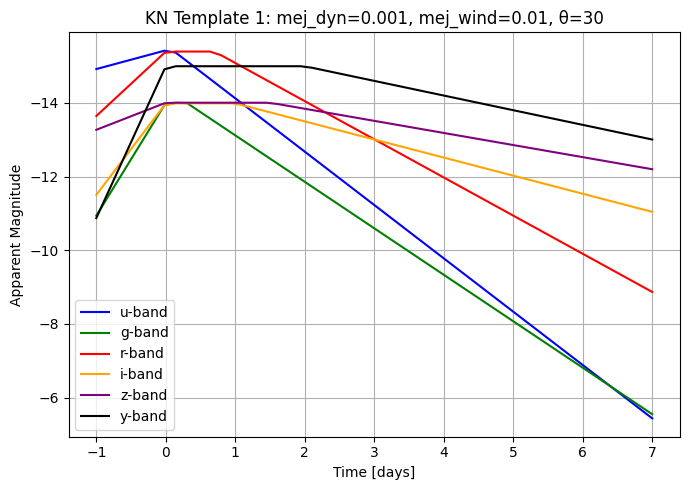

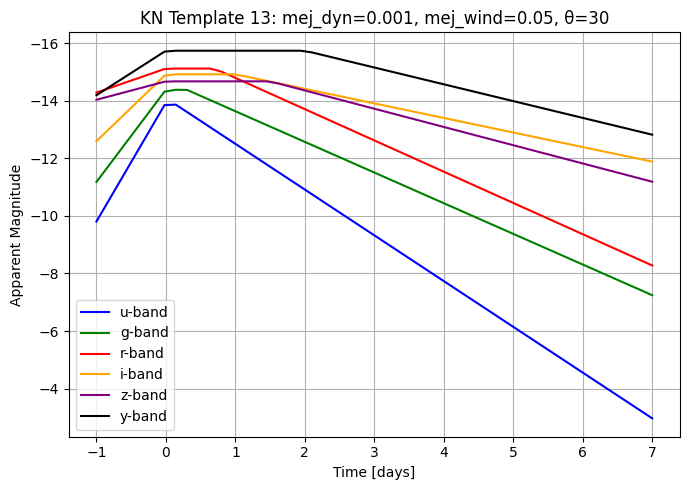

In [ ]:
# STEP 1: Load your template library
with open('KNe_templates.pkl', 'rb') as f:
    kne_templates = pickle.load(f)

print(f"Loaded {len(kne_templates)} kilonova templates.")

# STEP 2: Select 3 template indices to examine (or pick randomly!)
example_indices = [80, 1, 13]  # You can change these

# STEP 3: Plot light curves for each filter
filter_colors = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'orange',
    'z': 'purple',
    'y': 'black'
}

for idx in example_indices:
    template = kne_templates[idx]
    params = template['params']
    lc_data = template['lightcurve']

    plt.figure(figsize=(7, 5))
    for f in filters:
        t = lc_data[f]['t']
        mag = lc_data[f]['mag']
        plt.plot(t, mag, label=f"{f}-band", color=filter_colors[f])

    title_str = f"KN Template {idx}: mej_dyn={params['mej_dyn']}, mej_wind={params['mej_wind']}, θ={params['theta']}"
    plt.gca().invert_yaxis()
    plt.xlabel("Time [days]")
    plt.ylabel("Apparent Magnitude")
    plt.title(title_str)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#**Section 4**

In [ ]:
# RUN THIS

def m52snr(mag, limmag):
    """
    Approximate signal-to-noise ratio based on magnitude and 5-sigma limiting magnitude.

    Parameters:
        mag : float or np.ndarray
            Apparent magnitude of the source.
        limmag : float or np.ndarray
            5-sigma limiting magnitude of the observation.

    Returns:
        snr : float or np.ndarray
            Signal-to-noise ratio estimate.
    """
    snr = 5.0 * 10.0 ** (-0.4 * (mag - limmag))
    return snr


In [ ]:
def passes_detection(lightcurve, snr_thresh=3.0, min_detections=2, required_filters=['r','i'], time_gap_min=0.0105):
    """
    Check if an event passes the kilonova detection criteria.

    Parameters:
        lightcurve : dict
            Contains 'mjd', 'mag', 'limmag', 'filter' for one transient.
        snr_thresh : float
            Minimum signal-to-noise for a detection (e.g., 5).
        min_detections : int
            Minimum number of detections with SNR above threshold.
        required_filters : list
            Filters that must each have at least one detection.
        time_gap_min : float
            Minimum spacing (in days) between any two valid detections (~15 minutes = 0.0105 days).

    Returns:
        bool : True if detection criteria are met.
    """
    # Compute SNR
    snr = m52snr(lightcurve['mag'], lightcurve['limmag'])

    # Identify detections above threshold
    valid = snr >= snr_thresh
    if np.sum(valid) < min_detections:
        return False

    # Check for detections separated by at least 15 min
    mjds = np.array(lightcurve['mjd'])[valid]
    if len(mjds) < 2:
        return False
    if np.all(np.diff(np.sort(mjds)) < time_gap_min):
        return False

    # Filter coverage
    filters_used = set(np.array(lightcurve['filter'])[valid])
    if not set(required_filters).issubset(filters_used):
        return False

    return True

In [ ]:
def passes_characterization(lightcurve, rise_thresh=1.0, fade_thresh=0.3, time_gap_min=0.0105):
    """
    Check if an event passes characterization criteria.

    Parameters:
        lightcurve : dict
            Contains 'mjd', 'mag', 'filter' for one transient.
        rise_thresh : float
            Minimum rise rate in mag/day.
        fade_thresh : float
            Minimum fade rate in mag/day.
        time_gap_min : float
            Minimum spacing between points to trust slope estimate (~15 minutes).

    Returns:
        bool : True if rise/fade slopes can be measured and meet thresholds.
    """
    filters = np.unique(lightcurve['filter'])

    for f in filters:
        mask = np.array(lightcurve['filter']) == f
        if np.sum(mask) < 2:
            #print(f"Filter {f}: <2 data points")
            continue

        t = np.array(lightcurve['mjd'])[mask]
        m = np.array(lightcurve['mag'])[mask]

        if len(t) < 2:
            #print(f"Filter {f}: insufficient time points")
            continue

        idx = np.argsort(t)
        t = t[idx]
        m = m[idx]

        peak_idx = np.argmin(m)
        if peak_idx == 0 or peak_idx == len(m) - 1:
            #print(f"Filter {f}: Peak at edge (idx={peak_idx}, N={len(m)})")
            continue

        # Rise slope
        t_rise = t[:peak_idx+1]
        m_rise = m[:peak_idx+1]
        dt_rise = np.diff(t_rise)
        dm_rise = -np.diff(m_rise)
        valid_rise = dt_rise >= time_gap_min
        if not np.any(valid_rise):
            #print(f"Filter {f}: No valid rise slopes (dt < {time_gap_min})")
            continue
        rise_rate = np.max(dm_rise[valid_rise] / dt_rise[valid_rise])

        # Fade slope
        t_fade = t[peak_idx:]
        m_fade = m[peak_idx:]
        dt_fade = np.diff(t_fade)
        dm_fade = np.diff(m_fade)
        valid_fade = dt_fade >= time_gap_min
        if not np.any(valid_fade):
            #print(f"Filter {f}: No valid fade slopes (dt < {time_gap_min})")
            continue
        fade_rate = np.max(dm_fade[valid_fade] / dt_fade[valid_fade])

        #print(f"Filter: {f}, Rise: {rise_rate:.2f}, Fade: {fade_rate:.2f}")
        if rise_rate >= rise_thresh and fade_rate >= fade_thresh:
            return True

    return False


#**Section 5**

In [ ]:
# RUN THIS CELL

# Load masked cadence file from Section 2
with open("mock_cadence_masked.pkl", "rb") as f:
    pixel_obs_times = pickle.load(f)

# Load template light curves from Section 3
with open("KNe_templates.pkl", "rb") as f:
    templates = pickle.load(f)


In [ ]:
def inject_uniform_healpix(nside, n_events, seed=42):
    npix = hp.nside2npix(nside)
    rng = np.random.default_rng(seed)
    pix = rng.choice(npix, size=n_events)
    theta, phi = hp.pix2ang(nside, pix)
    ra = np.degrees(phi)
    dec = np.degrees(0.5 * np.pi - theta)
    return ra, dec, pix

def generate_KNe_population(n_events=2000, mjd_range=(60980.5, 64633), limmag_mean=24.5, limmag_std=0.3,
                            distance_bounds=(30, 250)):
    sfd = SFDQuery()
    pop = []
    meta = {
        'ra': [], 'dec': [], 'dist': [], 'ebv': [],
        'template_idx': [], 'peak_time': [],
        'detected': [], 'characterized': []
    }

    any_detected = 0
    any_characterized = 0

    ra_all, dec_all, pix_all = inject_uniform_healpix(nside=64, n_events=n_events)

    for i in range(n_events):
        ra = ra_all[i]
        dec = dec_all[i]
        pix = pix_all[i]

        coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
        ebv = sfd(coord)
        dist = np.random.uniform(*distance_bounds)
        dm = 5 * np.log10(dist * 1e6) - 5

        template_idx = np.random.randint(0, len(templates))
        template = templates[template_idx]['lightcurve']
        t_peak = np.random.uniform(*mjd_range)

        lc_event = {'mjd': [], 'mag': [], 'limmag': [], 'filter': []}

        for f in template:
            if pix not in pixel_obs_times or f not in pixel_obs_times[pix]:
                continue

            t_rel = template[f]['t']
            m = template[f]['mag']
            A_lambda = {'u': 4.9, 'g': 3.7, 'r': 2.7, 'i': 2.0, 'z': 1.5, 'y': 1.3}[f] * ebv
            m_app = m + dm + A_lambda

            for t_obs in pixel_obs_times[pix][f]:
                dt = t_obs - t_peak
                if dt < t_rel[0] or dt > t_rel[-1]:
                    continue
                idx = np.searchsorted(t_rel, dt)
                if idx >= len(m_app): continue
                mag = m_app[idx]
                limmag = np.random.normal(limmag_mean, limmag_std)

                if not np.isfinite(mag):
                    continue

                lc_event['mjd'].append(t_obs)
                lc_event['mag'].append(mag)
                lc_event['limmag'].append(limmag)
                lc_event['filter'].append(f)

        for k in lc_event:
            lc_event[k] = np.array(lc_event[k])

        # Evaluate detection/characterization
        snr = m52snr(lc_event['mag'], lc_event['limmag']) if len(lc_event['mag']) > 0 else np.array([])
        detected = False
        characterized = False

        if len(snr) > 0:
            detected = passes_detection(
                lc_event,
                snr_thresh=3.0,
                min_detections=1,
                required_filters=['r']
            )
            characterized = passes_characterization(
                lc_event,
                rise_thresh=0.3,
                fade_thresh=0.1
            ) if detected else False

        if detected:
            any_detected += 1
        if characterized:
            any_characterized += 1

        pop.append(lc_event)
        meta['ra'].append(ra)
        meta['dec'].append(dec)
        meta['dist'].append(dist)
        meta['ebv'].append(ebv)
        meta['template_idx'].append(template_idx)
        meta['peak_time'].append(t_peak)
        meta['detected'].append(detected)
        meta['characterized'].append(characterized)

    print(f"\nOut of {n_events} events:")
    print(f"  {any_detected} were detected")
    print(f"  {any_characterized} were characterized")

    return pop, meta


#**Section 6**


Out of 2000 events:
  150 were detected
  2 were characterized


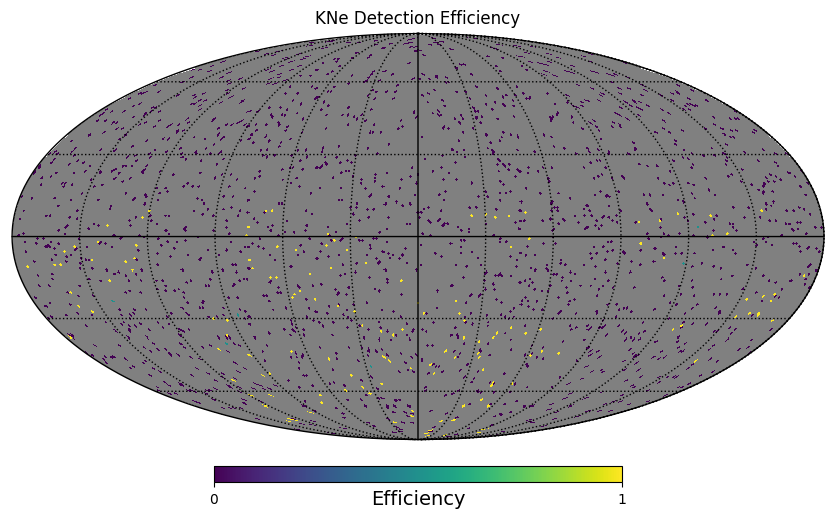

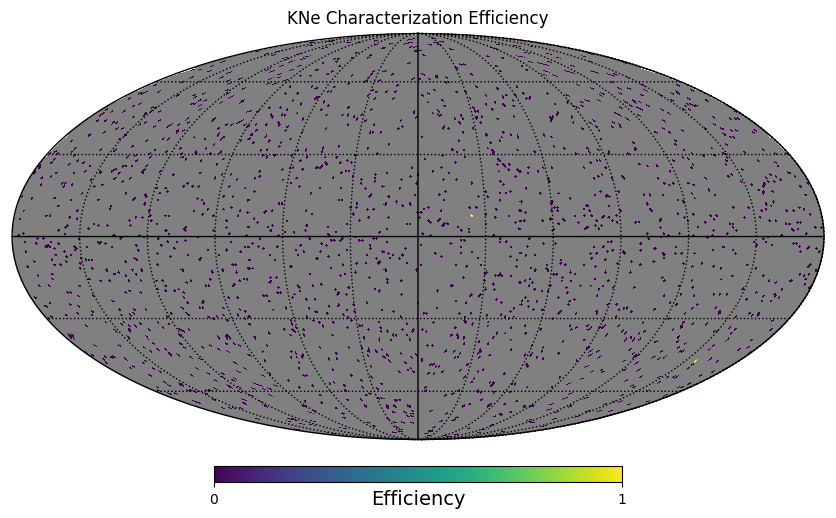

In [ ]:
# Generate and evaluate population
kne_pop, kne_meta = generate_KNe_population()

# === Sky Map Efficiency Plot (Detection and Characterization) ===

nside = 64
npix = hp.nside2npix(nside)

# Convert RA/Dec to HEALPix pixel indices
coords = SkyCoord(ra=np.array(kne_meta['ra']) * u.deg,
                  dec=np.array(kne_meta['dec']) * u.deg, frame='icrs')
pix_indices = hp.ang2pix(nside, 0.5 * np.pi - coords.dec.radian, coords.ra.radian)

# Initialize per-pixel counts
injected_map = np.zeros(npix)
detected_map = np.zeros(npix)
characterized_map = np.zeros(npix)

for i, pix in enumerate(pix_indices):
    injected_map[pix] += 1
    if kne_meta['detected'][i]:
        detected_map[pix] += 1
    if kne_meta['characterized'][i]:
        characterized_map[pix] += 1

# Efficiency maps
det_eff_map = np.zeros(npix) + hp.UNSEEN
char_eff_map = np.zeros(npix) + hp.UNSEEN

valid_pix = injected_map > 0
det_eff_map[valid_pix] = detected_map[valid_pix] / injected_map[valid_pix]
char_eff_map[valid_pix] = characterized_map[valid_pix] / injected_map[valid_pix]

# Detection Efficiency
hp.mollview(det_eff_map,
            title='KNe Detection Efficiency',
            unit='Efficiency',
            cmap='viridis',  #
            min=0, max=1)
hp.graticule()
plt.show()

# Characterization Efficiency
hp.mollview(char_eff_map,
            title='KNe Characterization Efficiency',
            unit='Efficiency',
            cmap='viridis',
            min=0, max=1)
hp.graticule()
plt.show()


#**Section 7**

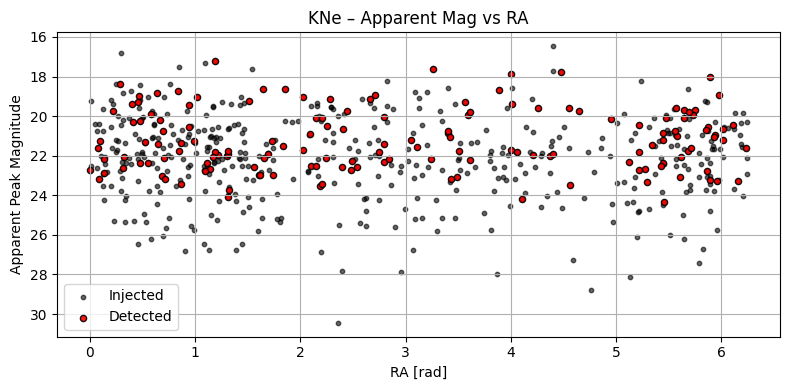

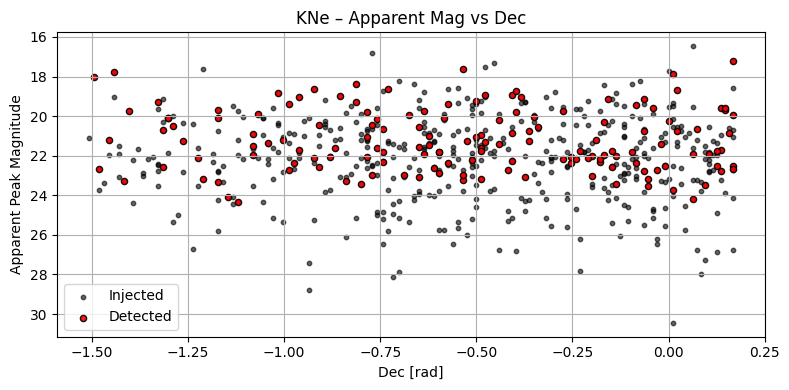

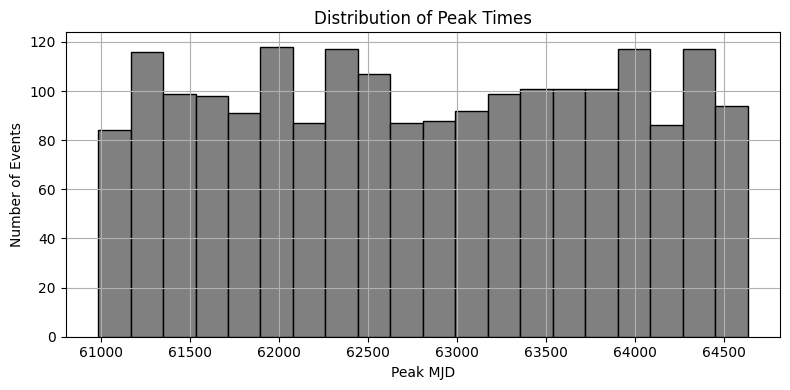

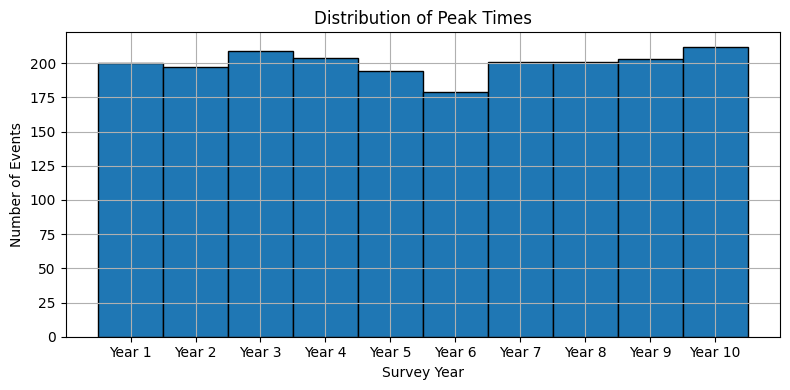

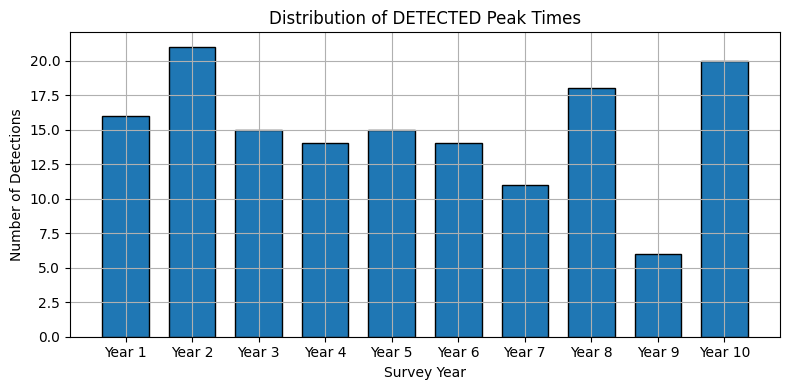

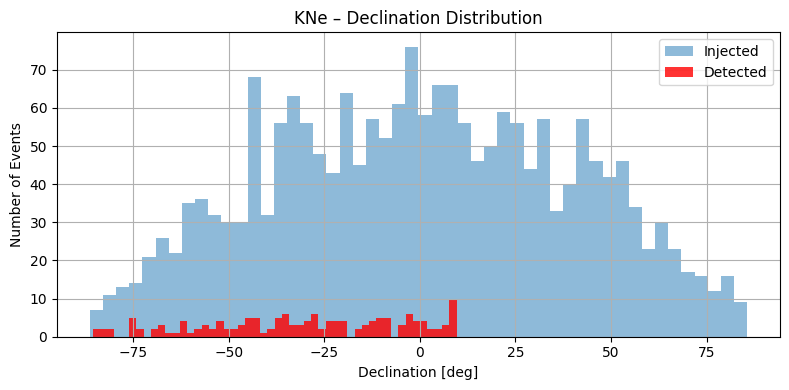

In [ ]:
# ------------------------------------------
# KNe Diagnostic Scatter Plots (RA/Dec vs mag)
# ------------------------------------------

# Convert to arrays
ras = np.radians(kne_meta['ra'])           # in radians
decs = np.radians(kne_meta['dec'])         # in radians
peak_mags = np.array([np.min(lc['mag']) if len(lc['mag']) > 0 else np.nan for lc in kne_pop])
detected_flags = np.array(kne_meta['detected'])
characterized_flags = np.array(kne_meta['characterized'])

# Plot: Apparent magnitude vs RA
plt.figure(figsize=(8, 4))
plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
plt.scatter(ras[detected_flags], peak_mags[detected_flags],
            c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
plt.xlabel("RA [rad]")
plt.ylabel("Apparent Peak Magnitude")
plt.title("KNe – Apparent Mag vs RA")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Apparent magnitude vs Dec
plt.figure(figsize=(8, 4))
plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
plt.scatter(decs[detected_flags], peak_mags[detected_flags],
            c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
plt.xlabel("Dec [rad]")
plt.ylabel("Apparent Peak Magnitude")
plt.title("KNe – Apparent Mag vs Dec")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Histogram of peak MJDs
plt.figure(figsize=(8, 4))
plt.hist(kne_meta['peak_time'], bins=20, color='gray', edgecolor='black')
plt.xlabel("Peak MJD")
plt.ylabel("Number of Events")
plt.title("Distribution of Peak Times")
plt.grid(True)
plt.tight_layout()
plt.show()

# Yearly histogram from peak_time
peak_times = np.array(kne_meta['peak_time'])
years = np.floor((peak_times - 60980.5) / 365).astype(int) + 1  # assuming year 1 starts ~MJD 59580
years = np.clip(years, 1, 10)

plt.figure(figsize=(8, 4))
plt.hist(years, bins=np.arange(0.5, 11.5, 1), edgecolor='black')
plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
plt.xlabel("Survey Year")
plt.ylabel("Number of Events")
plt.title("Distribution of Peak Times")
plt.grid(True)
plt.tight_layout()
plt.show()

# Detection histogram per year
det_years = years[detected_flags]
det_counts = np.bincount(det_years, minlength=11)[1:11]

plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, 11), det_counts, width=0.7, align='center', edgecolor='black')
plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
plt.xlabel("Survey Year")
plt.ylabel("Number of Detections")
plt.title("Distribution of DETECTED Peak Times")
plt.grid(True)
plt.tight_layout()
plt.show()

# Declination Histogram (deg)
plt.figure(figsize=(8, 4))
plt.hist(np.degrees(decs), bins=50, alpha=0.5, label='Injected')
plt.hist(np.degrees(decs[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
plt.xlabel("Declination [deg]")
plt.ylabel("Number of Events")
plt.title("KNe – Declination Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
